In [1]:
# import libraries
import matplotlib.pyplot as plt 
import numpy as np
from scipy.ndimage import convolve
from utils import * 
from multiprocessing import Pool
import os
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

In [4]:
# read in pistachios.csv
attributes = pd.read_csv('pistachios.csv')


In [54]:
#suffle our data :D
attributes = attributes.sample(frac=1)

In [55]:
# select 80% to be train and 20% to be test
val = int(attributes.shape[0]*.8)
train = attributes.iloc[:val,:]
test = attributes.iloc[val:,:]
xtrain = train.iloc[:,4:]
ytrain = train.iloc[:,3]
xtest = test.iloc[:,4:]
ytest = test.iloc[:,3]

In [56]:
# run random forest to see most important features
rforest = RandomForestClassifier()
rforest.fit(xtrain , ytrain)
ypred = rforest.predict(xtest)
rforest.score(xtest,ytest)

0.8697674418604651

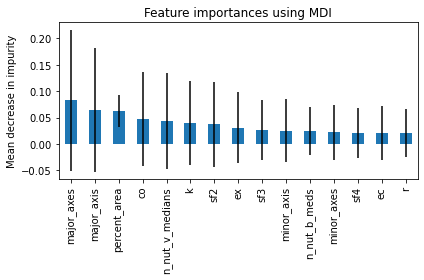

In [57]:
# visualize most important features
feature_names = [f"{i}" for i in attributes.columns[:-1] ] #range(features.iloc[:,:-1].shape[1])
feature_names = feature_names[3:]
importances = rforest.feature_importances_
std = np.std([tree.feature_importances_ for tree in rforest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
d = {'feature':feature_names, 'importances':importances,'std':std}
forest_imp = pd.DataFrame(d, index=feature_names)
forest_imp = forest_imp.sort_values(by='importances', ascending=False)
sub_forest_importances = forest_imp['importances'].iloc[:15]
substd = forest_imp['std'].iloc[:15]
fig, ax = plt.subplots()
sub_forest_importances.plot.bar(yerr=substd, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<AxesSubplot:>

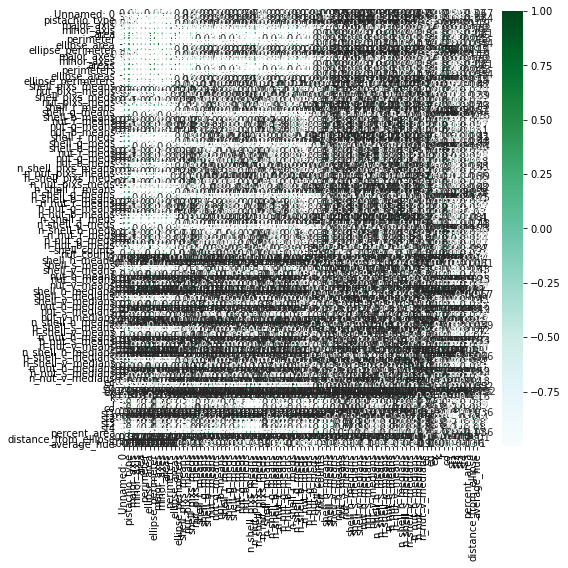

In [58]:
# Perform correlation analysis (maybe needed- most likely delete or reduce
correlation = attributes.corr()
plt.figure(figsize=(8,8))
sns.heatmap(correlation,
            cmap='BuGn',
            linecolor='white',
            linewidths=1,
            annot=True, 
            xticklabels = True,
            yticklabels= True)

In [59]:
# set a baseline dummy model
dummy = DummyClassifier(strategy='stratified', random_state = 1)
#train the model with training data
dummy.fit(xtrain, ytrain)
#get accuracy score
baseline_accuracy = round(dummy.score(xtest, ytest),2)
print(f"Our dummy algorithm classified {baseline_accuracy*100}% of the trees correctly")

Our dummy algorithm classified 47.0% of the trees correctly


In [60]:
# build KNN Model
KNN_model = KNeighborsClassifier(n_neighbors = 5)
KNN_model.fit(xtrain, ytrain)
KNN_model_accuracy = round(KNN_model.score(xtest, ytest),5)
print(f"The accuracy of the original KNN model with the full data set is {KNN_model_accuracy*100}%")

The accuracy of the original KNN model with the full data set is 73.256%


### We will attempt to improve upon our Random Forest model by analyzing a KNN model as well and modifying the following hyperparameters: 
- Number of neighbors 
- Weights 
- Distance formula (Manhattan or Euclidean) 

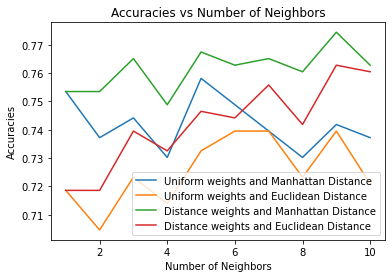

In [61]:
#hyperparameter tune
# set hyperparameters
n = [1,2,3,4,5,6,7,8,9,10] # number of neighbors
w_u = 'uniform' # weights{‘uniform’, ‘distance’} or callable, default=’uniform’
w_d = 'distance'
p_value_m = 1 #Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2, default=2
p_value_e = 2

# Create KNN models across different numbers of neighbors
UM_combined_accuracies = []
UE_combined_accuracies = []
DM_combined_accuracies = []
DE_combined_accuracies = []


for i in n:
  UM_model = KNeighborsClassifier(n_neighbors=i, weights=w_u, p=p_value_m)
  UM_model.fit(xtrain, ytrain)
  UE_model = KNeighborsClassifier(n_neighbors=i, weights=w_u, p=p_value_e)
  UE_model.fit(xtrain, ytrain)
  DM_model = KNeighborsClassifier(n_neighbors=i, weights=w_d, p=p_value_m)
  DM_model.fit(xtrain, ytrain)
  DE_model = KNeighborsClassifier(n_neighbors=i, weights=w_d, p=p_value_e)
  DE_model.fit(xtrain, ytrain)  

  # Determine the main metric of evaluation: Accuracy
  UM_model_accuracy = UM_model.score(xtest, ytest)
  UM_combined_accuracies.append(UM_model_accuracy)
  UE_model_accuracy = UE_model.score(xtest, ytest)
  UE_combined_accuracies.append(UE_model_accuracy)
  DM_model_accuracy = DM_model.score(xtest, ytest)
  DM_combined_accuracies.append(DM_model_accuracy)
  DE_model_accuracy = DE_model.score(xtest, ytest)
  DE_combined_accuracies.append(DE_model_accuracy)

# Plot impact of number of neighbors on accuracies 
plt.figure()
plt.plot(n, UM_combined_accuracies, label = "Uniform weights and Manhattan Distance")
plt.plot(n, UE_combined_accuracies, label = "Uniform weights and Euclidean Distance")
plt.plot(n, DM_combined_accuracies, label = "Distance weights and Manhattan Distance")
plt.plot(n, DE_combined_accuracies, label = "Distance weights and Euclidean Distance")
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracies')
plt.legend()
plt.title('Accuracies vs Number of Neighbors')
plt.show()

Accuracy of the KNN model with distance weights, Manhattan Distance, and 9 neighbors is 77.0%
The classification of KNN model is 
               precision    recall  f1-score   support

           0       0.77      0.82      0.80       233
           1       0.77      0.72      0.74       197

    accuracy                           0.77       430
   macro avg       0.77      0.77      0.77       430
weighted avg       0.77      0.77      0.77       430



Text(69.0, 0.5, 'Truth')

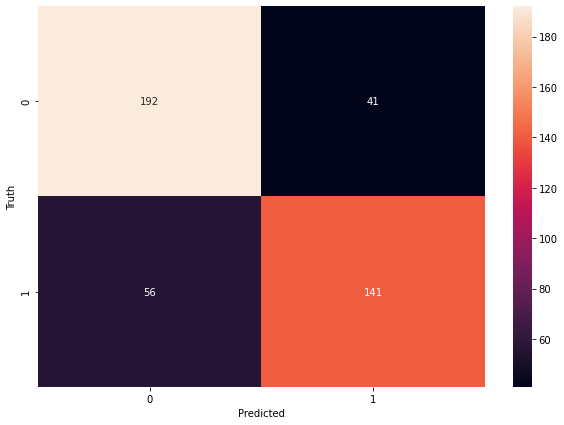

In [62]:
# set parameters for best model
# Create KNN model
best_KNN_model = KNeighborsClassifier(n_neighbors=9, weights='distance', p=1)
best_KNN_model.fit(xtrain, ytrain)

# Determine the main metric of evaluation: Accuracy
best_KNN_model_accuracy = best_KNN_model.score(xtest, ytest)
print(f"Accuracy of the KNN model with distance weights, Manhattan Distance, and 9 neighbors is {100*round(best_KNN_model_accuracy,2)}%")

# Determine the supplementary metrics of evaluation: Precision, Recall, and F1
KNN_pred_labels = best_KNN_model.predict(xtest)
KNN_classification = classification_report(ytest, KNN_pred_labels) # reports Precision, Recall, and F1 Score
print(f"The classification of KNN model is \n {KNN_classification}")

# Create a confusion matrix for the model
cmKNN = confusion_matrix(ytest, KNN_pred_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cmKNN ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')